# Global Forecasting and Foundation Models

### Overview of this notebook

* Global Forecasting
    * Introduction
    * Example with/without exogenous data
    * Global Forecasters in sktime
* Foundation Models
    * Introduction
    * Examples
    * Sktime Vendors
* Recap
* Credits

In [1]:
import warnings

warnings.filterwarnings("ignore")

## Global Forecasting

global forecasting = (pre-)training model on examples, to later forecast

Common examples:

* transformer based deep learning forecasters, pre-training and fine-tuning
* reduction forecasters with sklearn regressors trained on larger sample

<img src="./img/global-fcst.png" alt="Global Forecast" style="width: 100%; max-width: 600px;">

Mathematically, vanilla case:

   - train on dataset containing $n$ time series $y_1(t), y_2(t), \dots, y_N(t)$
   - forecast on another time series $y^*(t)$
       - given $y^*(t_1), \dots, y^*(t_T),$ produce forecasts $y^*(t_T + h_1), \dots, y^*(t_T + h_H)$

basic `sktime` interface for global forecasting:

```python
model.fit(y=y_train, fh=fh)
model.predict(y=y_deploy)  # new time series passed in predict!
```

To search for global forecasters, use the `capability:global_forecasting` tag:

In [2]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingDeepAR

PytorchForecastingDeepAR().get_tag(
    "capability:global_forecasting"
)  # should return True

True

### Example

The data is from the [Stallion kaggle competition](https://www.kaggle.com/datasets/utathya/future-volume-prediction).

In [3]:
from utils import load_stallion

X, y = load_stallion()

#### Global Forecasting without exogeneous data

First, let's try to fit and predict without exogeneous data

In [4]:
from sktime.forecasting.base import ForecastingHorizon

fh = ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9], is_relative=True, freq="MS")

from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y, test_size=0.1, train_size=0.9, shuffle=False)
y_true = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[-max(fh):])
y_test = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[:-max(fh)])

`y_train` is the series we want to fit on which contains the first 90% of the time series instances.

In [5]:
y_train

volume
agency    sku    date                  
Agency_01 SKU_01 2013-01-01    80.67600
                 2013-02-01    98.06400
                 2013-03-01   133.70400
                 2013-04-01   147.31200
                 2013-05-01   175.60800
...                                 ...
Agency_55 SKU_05 2017-08-01  1058.95050
                 2017-09-01   909.68025
                 2017-10-01  1156.84560
                 2017-11-01   902.71500
                 2017-12-01  1202.59800

[18900 rows x 1 columns]

`y_test` is the series we want to predict on which contains the last 10% of the time series instances.

In [6]:
y_test

volume
agency    sku    date                
Agency_56 SKU_01 2013-01-01  2999.160
                 2013-02-01  3541.212
                 2013-03-01  4057.992
                 2013-04-01  4152.276
                 2013-05-01  4885.488
...                               ...
Agency_60 SKU_23 2016-11-01     0.360
                 2016-12-01     3.510
                 2017-01-01     2.160
                 2017-02-01     2.520
                 2017-03-01     1.710

[1785 rows x 1 columns]

You can see that `y_train` and `y_test` are different on hierarchical level which indicates that they come from different instances.

We can initialize a global forecaster to fit on `y_train` and predict on `y_test`.

In [7]:
from sktime.forecasting.pytorchforecasting import PytorchForecastingNBeats

model = PytorchForecastingNBeats(
    trainer_params={
        "max_epochs": 10,
    },
)

In [8]:
# This could take 1 min to fit the data
model.fit(y=y_train, fh=fh)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
2024-08-27 12:24:04.712858: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-08-27 12:24:04.712879: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | loss            | MASE       | 0      | train
1 | logging_metrics | ModuleList | 0      | train
2 | net_blocks      | ModuleList | 1.6 M  | train
-------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.588     Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


PytorchForecastingNBeats(trainer_params={'max_epochs': 10})

Then we can predict on `y_test` which is not included in `y_train`.

In [9]:
y_pred = model.predict(y=y_test, fh=fh)
y_pred

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


volume
agency    sku    date                   
Agency_56 SKU_01 2017-04-01  3984.181152
                 2017-05-01  4060.038086
                 2017-06-01  4106.142090
                 2017-07-01  4104.164551
                 2017-08-01  4048.289551
...                                  ...
Agency_60 SKU_23 2017-08-01     1.740142
                 2017-09-01     1.445430
                 2017-10-01     1.060455
                 2017-11-01     1.019034
                 2017-12-01     1.633375

[315 rows x 1 columns]

`y_pred` have the same instance index as `y_test`.

We can plot one series to see the result. As we train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='volume'>)

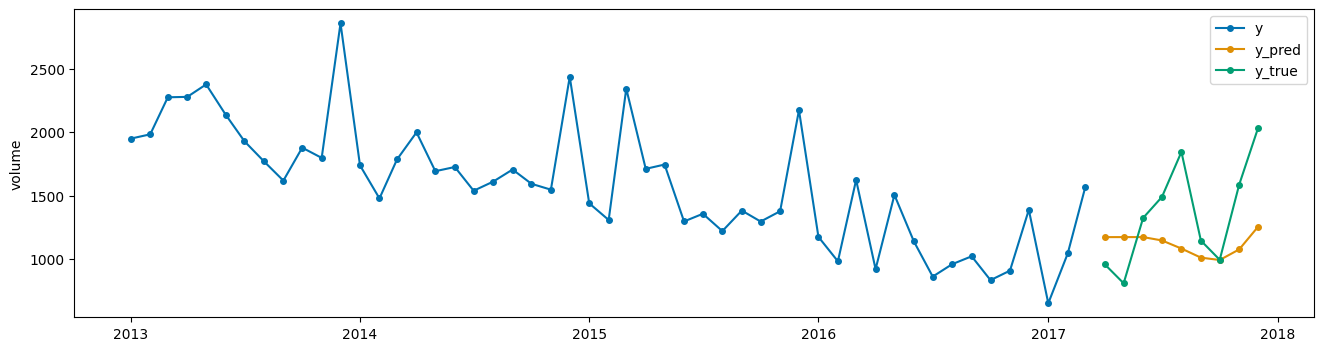

In [10]:
from sktime.utils.plotting import plot_series
ins=("Agency_59","SKU_04")
plot_series(
    y_test.loc[ins],
    y_pred.loc[ins],
    y_true.loc[ins],
    labels=["y", "y_pred", "y_true"],
)

#### Global Forecasting with exogeneous data

Then let's try to fit and predict with exogeneous data

When we predict with exogeneous data, we need to pass both `X` and `y` to `predict`.

`X` must contain all historical values and the time points to be predicted while `y` should only contain the historical values but not the time points to be predicted.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, train_size=0.9, shuffle=False
)
y_true = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[-max(fh):])
y_test = y_test.groupby(level=[0,1]).apply(lambda x: x.droplevel([0,1]).iloc[:-max(fh)])

`X_train` and `y_train` have the same time index from 2000-01-01 to 2000-01-10.

However `y_test` is shorter than `X_test`. 

`X_test` has the time index from 2013-01-01 to 2017-12-01 but `y_test` only has the time index from 2013-01-01 to 2017-03-01. 

This is because we don't know the values from 2017-4-01 to 2017-12-01 of `y_test` which are going to be forecasted.

In [12]:
y_test

volume
agency    sku    date                
Agency_56 SKU_01 2013-01-01  2999.160
                 2013-02-01  3541.212
                 2013-03-01  4057.992
                 2013-04-01  4152.276
                 2013-05-01  4885.488
...                               ...
Agency_60 SKU_23 2016-11-01     0.360
                 2016-12-01     3.510
                 2017-01-01     2.160
                 2017-02-01     2.520
                 2017-03-01     1.710

[1785 rows x 1 columns]

In [13]:
# This could take 1 min to fit the data
from sktime.forecasting.pytorchforecasting import PytorchForecastingNHiTS

model = PytorchForecastingNHiTS(
    trainer_params={
        "max_epochs": 10,  # for quick test
    },
)

model.fit(y=y_train, X=X_train, fh=fh)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type           | Params | Mode 
-----------------------------------------------------------
0 | loss            | MASE           | 0      | train
1 | logging_metrics | ModuleList     | 0      | train
2 | embeddings      | MultiEmbedding | 0      | train
3 | model           | NHiTS          | 2.0 M  | train
-----------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.033     Total estimated model params size (MB)
35        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


PytorchForecastingNHiTS(trainer_params={'max_epochs': 10})

Now we can predict on `y_test` with `X_test`.

`y_test` is shorter than `X_test` as `y_test` only contains the historical values not the time points to be predicted.

In [14]:
y_pred = model.predict(fh=fh, X=X_test, y=y_test)
y_pred

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


volume
agency    sku    date                   
Agency_56 SKU_01 2017-04-01  4029.122314
                 2017-05-01  4480.708008
                 2017-06-01  4041.663086
                 2017-07-01  3777.022705
                 2017-08-01  3863.573730
...                                  ...
Agency_60 SKU_23 2017-08-01    -0.708586
                 2017-09-01    -0.623689
                 2017-10-01    -0.955707
                 2017-11-01    -1.065455
                 2017-12-01    -0.933613

[315 rows x 1 columns]

We can plot one series to see the result. As we train the model for a few epochs, we can not expect too much.

(<Figure size 1600x400 with 1 Axes>, <Axes: ylabel='volume'>)

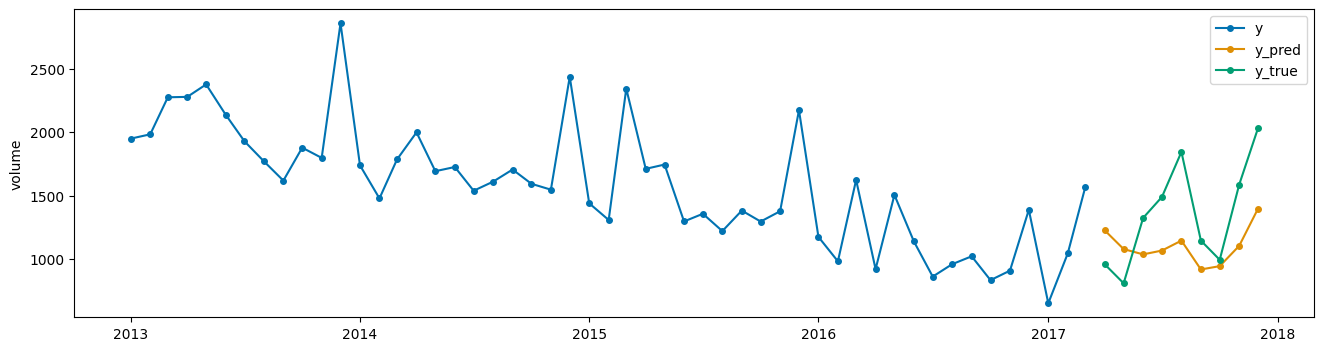

In [15]:
ins=("Agency_59","SKU_04")
plot_series(
    y_test.loc[ins],
    y_pred.loc[ins],
    y_true.loc[ins],
    labels=["y", "y_pred", "y_true"],
)

### Global Forecasters in sktime

List of the global forecasters available in sktime

In [16]:
from sktime.registry import all_estimators

all_estimators(
	"forecaster",
	filter_tags={"capability:global_forecasting": True},
	as_dataframe=True,
)

,name,object
0,PytorchForecastingDeepAR,<class 'sktime.forecasting.pytorchforecasting....
1,PytorchForecastingNBeats,<class 'sktime.forecasting.pytorchforecasting....
2,PytorchForecastingNHiTS,<class 'sktime.forecasting.pytorchforecasting....
3,PytorchForecastingTFT,<class 'sktime.forecasting.pytorchforecasting....
4,TimesFMForecaster,<class 'sktime.forecasting.timesfm_forecaster....
5,TinyTimeMixerForecaster,<class 'sktime.forecasting.ttm.TinyTimeMixerFo...


More expected models with global forecasting interface in future - [ [ENH] Make forecasters global - Wishlist #6836 ](https://github.com/sktime/sktime/issues/6836)

## Foundation models

**What is a foundation model?**

A foundation model is a large, **pre-trained deep learning model** that serves as a versatile base for various downstream tasks.

Typically:
* uses "transformer" or other advanced deep learning architecture
* weights need to be downloaded and handled
* 2024 state: model code not easily installable!
    * most models have no proper package releases
    * heavy or conflicted dependency sets
    * commercial open source with "lock-in" or "lock-down" flavour

`sktime`-less users need to manage:
* **model code**, e.g., source installation
* **model code dependencies**, python packages
* **weights**, e.g., .pkl, .pt, .bin, .h5 files
* **weight dependencies**, python packages

`sktime` API abstracts this away and manages on framework level

<img src="./img/fm-simple.png" alt="Foundation Model Overview" style="width: 100%; max-width: 600px;">

### Examples

In [17]:
from sktime.datasets import load_airline

# Load the dataset for example
y = load_airline()

In [18]:
# keep same prediction length for all examples
pred_len = 16

In [19]:
# import plotting function
from sktime.utils.plotting import plot_series

#### Huggingface Transformers

Forecaster that uses a huggingface model for forecasting.

This forecaster fetches the model from the huggingface model hub.

Note, this forecaster is in an experimental state. It is currently only
working for Informer, Autoformer, and TimeSeriesTransformer.

In [20]:
from sktime.forecasting.hf_transformers_forecaster import HFTransformersForecaster

`model_path`

You can provide path to a huggingface repo or a local folder that contains model config and 
weights

For-example
- huggingface/informer-tourism-monthly
- huggingface/autoformer-tourism-monthly
- huggingface/time-series-transformer-tourism-monthly

In [21]:
forecaster = HFTransformersForecaster(
    model_path = "huggingface/informer-tourism-monthly",
)

`fit_strategy`
- "minimal": Fine-tunes only newly initialized model parameters,
    allowing for quick adaptation with limited computational resources.

In [22]:
forecaster = HFTransformersForecaster(
    model_path = "huggingface/informer-tourism-monthly",
    fit_strategy = "minimal",
)

- "full": Fine-tunes all model parameters, which may result in better
    performance but requires more computational power and time.

In [23]:
forecaster = HFTransformersForecaster(
    model_path = "huggingface/informer-tourism-monthly",
    fit_strategy = "full",
)

- "peft": Applies Parameter-Efficient Fine-Tuning (PEFT) techniques to adapt
    the model with fewer trainable parameters, saving computational resources.
    Note: If the 'peft' package is not available, a `ModuleNotFoundError` will
    be raised, indicating that the 'peft' package is required. Please install
    it using `pip install peft` to use this fit strategy.

In [24]:
from peft import LoraConfig

forecaster = HFTransformersForecaster(
    model_path = "huggingface/informer-tourism-monthly",
    fit_strategy = "peft",
    peft_config=LoraConfig(
        r=8,
        lora_alpha=32,
        target_modules=["q_proj", "v_proj"],
        lora_dropout=0.01,
    )
)

Initializing model for the example

In [25]:
forecaster = HFTransformersForecaster(
    model_path = "huggingface/informer-tourism-monthly",
    fit_strategy = "full",
    training_args = {
        "num_train_epochs": 30,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
    },
    config = {
        "lags_sequence": [1, 12, 24],
        "context_length": 24,
        "prediction_length": pred_len,
        "use_cpu": True,
        "label_length": 8,
    },
    deterministic = True,
)

In [26]:
forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

Some weights of the model checkpoint at huggingface/informer-tourism-monthly were not used when initializing InformerForPrediction: ['model.embedder.embedders.0.weight']
- This IS expected if you are initializing InformerForPrediction from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing InformerForPrediction from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of InformerForPrediction were not initialized from the model checkpoint at huggingface/informer-tourism-monthly and are newly initialized because the shapes did not match:
- model.encoder.value_embedding.value_projection.weight: found shape torch.Size([32, 22]) in the checkpoint and torch.Size([32, 5]) in the model instantiated
- model.en

  0%|          | 0/60 [00:00<?, ?it/s]

{'train_runtime': 5.6039, 'train_samples_per_second': 273.024, 'train_steps_per_second': 10.707, 'train_loss': 6.647856648763021, 'epoch': 30.0}


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

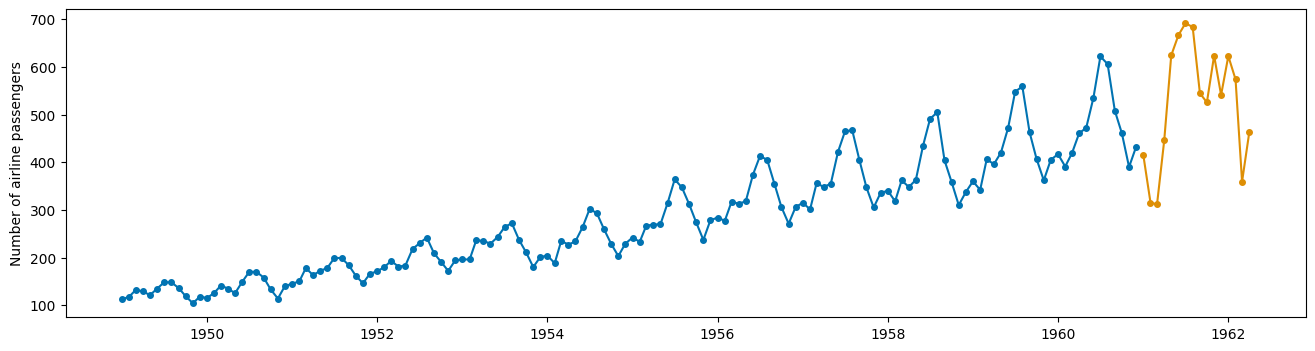

In [27]:
plot_series(y, y_pred)

#### TinyTimeMixer

TinyTimeMixer (TTM) is a compact, pre-trained model for time-series forecasting, developed and open-sourced by IBM Research.

- **Research Paper:** [Tiny Time Mixers (TTMs): Fast Pre-trained Models for Enhanced Zero/Few-Shot Forecasting of Multivariate Time Series](https://www.researchgate.net/profile/Vijay-Ekambaram/publication/381111250_Tiny_Time_Mixers_TTMs_Fast_Pre-trained_Models_for_Enhanced_ZeroFew-Shot_Forecasting_of_Multivariate_Time_Series/links/665d8c5d0b0d2845747de5f5/Tiny-Time-Mixers-TTMs-Fast-Pre-trained-Models-for-Enhanced-Zero-Few-Shot-Forecasting-of-Multivariate-Time-Series.pdf)
- **Official Code:** [ibm-granite/granite-tsfm](https://github.com/ibm-granite/granite-tsfm)

In [28]:
from sktime.forecasting.ttm import TinyTimeMixerForecaster

**Zero-Shot Forecasting**

with the default configuration, model performs zero-shot

In [29]:
forecaster = TinyTimeMixerForecaster()

forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

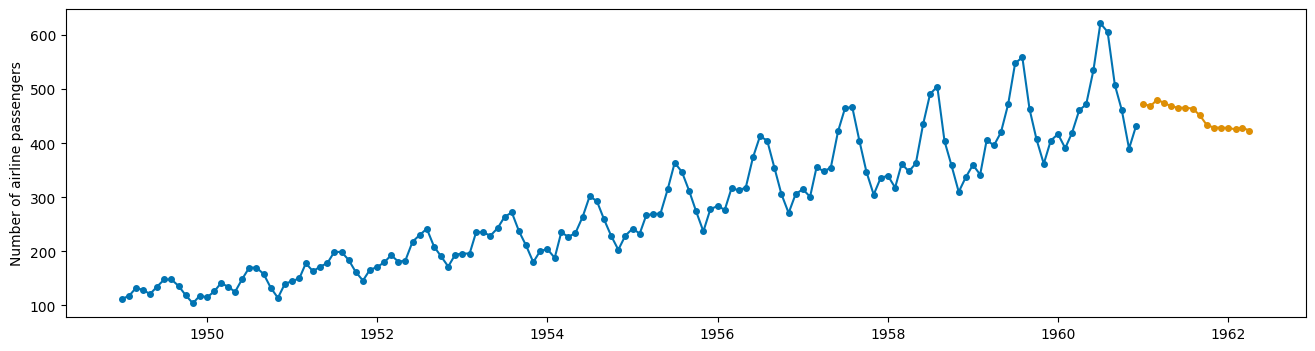

In [30]:
plot_series(y, y_pred)

**Fine-Tuning**

when a different configuration is provided, some weights are re-initialized and fine-tuned

In [31]:
forecaster = TinyTimeMixerForecaster(
    config={
        "context_length": 32,
        "prediction_length": pred_len,
    },
    training_args={
        "num_train_epochs": 100,
        "output_dir": "test_output",
        "per_device_train_batch_size": 32,
        "report_to": "none",
        "learning_rate": 1e-2,
    },
)
forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

Some weights of TinyTimeMixerForPrediction were not initialized from the model checkpoint at ibm/TTM and are newly initialized because the shapes did not match:
- backbone.encoder.patcher.weight: found shape torch.Size([192, 64]) in the checkpoint and torch.Size([192, 4]) in the model instantiated
- head.base_forecast_block.bias: found shape torch.Size([96]) in the checkpoint and torch.Size([16]) in the model instantiated
- head.base_forecast_block.weight: found shape torch.Size([96, 1024]) in the checkpoint and torch.Size([16, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/300 [00:00<?, ?it/s]

{'train_runtime': 17.718, 'train_samples_per_second': 383.791, 'train_steps_per_second': 16.932, 'train_loss': 289.96348958333334, 'epoch': 100.0}


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

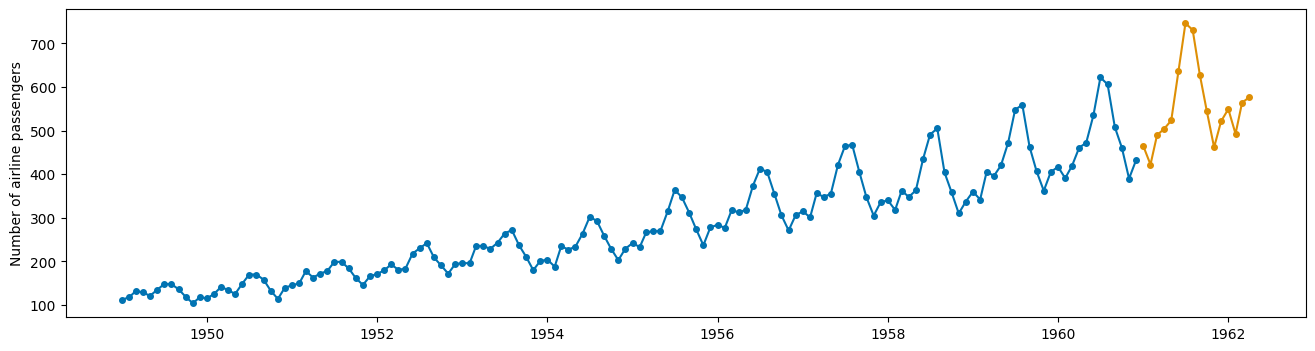

In [32]:
plot_series(y, y_pred)

#### TimesFM

TimesFM (Time Series Foundation Model) is a pre-trained model developed by Google Research, designed specifically for zero-shot forecasting.

- **Research Paper:** [A Decoder-Only Foundation Model for Time-Series Forecasting](https://arxiv.org/abs/2310.10688)
- **Official Code:** [google-research/timesfm](https://github.com/google-research/timesfm)

**Note**: `TimesFM` is supported only on `Linux` and `python==3.10`

In [33]:
# !pip install tensorflow einshape jax praxis huggingface-hub paxml utilsforecast

**Zero-Shot Forecasting**

In [35]:
from sktime.forecasting.timesfm_forecaster import TimesFMForecaster

forecaster = TimesFMForecaster(
    context_len=64,
    horizon_len=pred_len,
)

In [37]:
forecaster.fit(y, fh=list(range(1, pred_len+1)))
y_pred = forecaster.predict()

Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


(<Figure size 1600x400 with 1 Axes>,
 <Axes: ylabel='Number of airline passengers'>)

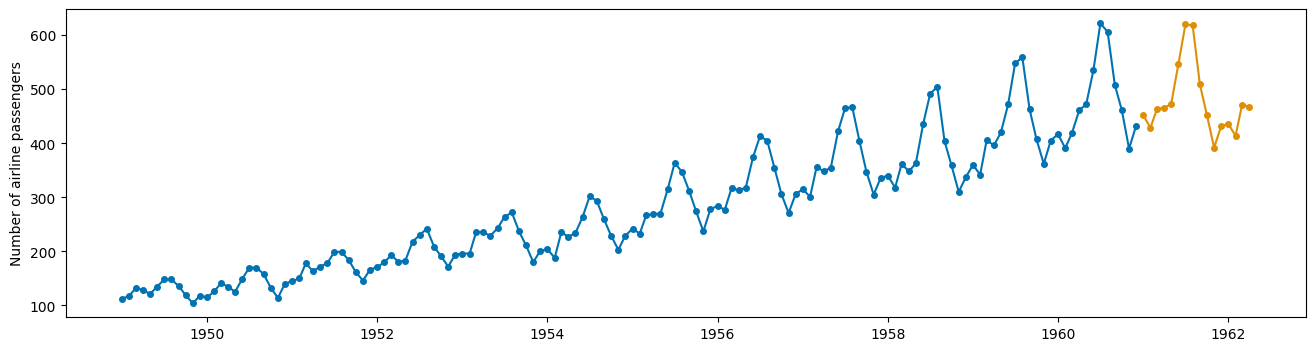

In [38]:
plot_series(y, y_pred)

More Foundation Models to come in future - [#6177](https://github.com/sktime/sktime/issues/6177)

Here are a few foundation models in progress 
| Foundation Model  | Pull Request                                    | Contributor                  |
|-------------------|-------------------------------------------------|------------------------------|
| Amazon Chronos    | [PR #6665](https://github.com/sktime/sktime/pull/6665) | [Z-Fran](https://github.com/Z-Fran)         |
| LagLlama          | [PR #6659](https://github.com/sktime/sktime/pull/6659) | [shlok191](https://github.com/shlok191)     |
| MOIRAI            | [PR #6299](https://github.com/sktime/sktime/pull/6299) | [pranavvp16](https://github.com/pranavvp16) |
| TimesFM           | [PR #6571](https://github.com/sktime/sktime/pull/6571) | [geetu040](https://github.com/geetu040)     |
| MomentFM          | [PR #6570](https://github.com/sktime/sktime/pull/6570) | [julian-fong](https://github.com/julian-fong) |


### Sktime Vendor Fork

sktime may fork some code from the official source because of
* dependency issues
* unavailability on pypi
* license change

This forked code goes into [`sktime/libs`](TODO), and the license attached with the official code is kept as is in the fork

Source installation can be selected via `use_source_package` parameter

For example you want to use `TinyTimeMixer` from the source package

1. install the package

In [39]:
!pip install git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.3 --quiet

2. set the `use_source_package` flag to `True`

In [40]:
forecaster = TinyTimeMixerForecaster(
    use_source_package=True,
)

## Recap


**Global Forecasting**

* Involves training models on multiple time series to make forecasts on new series.
* Demonstrated with SKU volume prediction using sktime, both with and without exogenous data.

**Foundation Models**

* Large, pre-trained deep learning models designed for versatility across various tasks.
* Showcased models: Informer, Autoformer, and TinyTimeMixer.
* Training Approaches like fine-tuning, minimal training, and PEFT methods.
* License Management with foundation models.

## What's Next?

Customization with sktime
* New sktime model marketplace
* Developing the 2nd-party library
    * Overview of creating a custom forecaster
    * Implementing the model
    * Testing the model

---
## Credits: notebook 3 - `global forecasting`

notebook creation: xinyu, geetu, fkiraly, felipe

global forecasting interface: xinyu

General credit also to `sklearn` and `sktime` contributors